In [40]:
import pandas as pd
import numpy as np
import warnings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from script import create_time_series
from fsrs_optimizer import Optimizer, Trainer
from fsrs_optimizer import Collection, power_forgetting_curve, rmse_matrix
from collections import defaultdict
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

lr: float = 4e-2
n_epoch: int = 5
batch_size: int = 512
# look_ahead: int = 100  # Number of reviews between optimisations. Moved to the function call
verbose: bool = False
optimizer = Optimizer()

def plot_file(file, look_ahead, cumulative_data=None, plot_individual=False, plot_cumulative=False):
    if cumulative_data is None:
        cumulative_data = [[], [], []]
    dataset = pd.read_csv(file)[:5000]
    dataset = create_time_series(dataset).reset_index()
    optimized_list = []
    dry_run_list = []
    pretrain_list = []
    testsets = []

    max_pow = np.floor(np.log2(len(dataset)))

    indexes = [2**i for i in range(3, int(max_pow) + 1)]
    indexes = [i for i in indexes if i <= 4096]
    # print(indexes)

    for max_index in indexes:
        train_set = dataset.loc[:max_index].copy()
        test_set = dataset.loc[max_index : min(max_index + look_ahead + 1, len(dataset) - 1)].copy()
        testsets.append(test_set)
        optimizer.define_model()
        dry_run_list.append(optimizer.init_w.copy())

        optimizer.S0_dataset_group = (
            train_set[train_set["i"] == 2]
            .groupby(by=["r_history", "delta_t"], group_keys=False)
            .agg({"y": ["mean", "count"]})
            .reset_index()
        )
        _ = optimizer.pretrain(dataset=train_set, verbose=verbose)
        pretrain_list.append(optimizer.init_w.copy())

        try:
            trainer = Trainer(
                train_set,
                None,
                optimizer.init_w,
                n_epoch=n_epoch,
                lr=lr,
                batch_size=batch_size,
            )
            optimized_list.append(trainer.train(verbose=verbose))
        except Exception as e:
            if str(e) != "Training data is inadequate.":
                print(e)
            optimized_list.append(optimizer.init_w.copy())

    rmses = defaultdict(list)
    loglosses = defaultdict(list)
    for i, (w1, w2, w3, testset) in enumerate(zip(optimized_list, pretrain_list, dry_run_list, testsets)):
        for j, w in enumerate((w1, w2, w3)):
            my_collection = Collection(w)
            stabilities, difficulties = my_collection.batch_predict(testset)
            testset["p"] = power_forgetting_curve(testset["delta_t"], stabilities)
            rmse = rmse_matrix(testset)
            rmses[j].append(rmse)
            logloss = log_loss(testset["y"], testset["p"], labels=[0, 1])
            loglosses[j].append(logloss)

    if plot_individual:
        plt.plot(indexes, rmses[0], label="optimised")
        plt.plot(indexes, rmses[1], label="pretrain")
        plt.plot(indexes, rmses[2], label="dry_run")
        plt.title("RMSE")
        plt.ylim(0, max(rmses[0] + rmses[1] + rmses[2]))
        plt.semilogx()
        plt.legend()
        plt.show()

    # Cumulative version
    cumulative_data[0].append(rmses[0])
    cumulative_data[1].append(rmses[1])
    cumulative_data[2].append(rmses[2])
    cumulative_means = [[], [], []]
    for i in range(3):
        this_vals = [[] for _ in range(len(indexes))]
        for this_rmses in cumulative_data[i]:
            for j, rmse in enumerate(this_rmses):
                if j >= len(indexes):
                    break
                this_vals[j].append(rmse)
        for j in range(len(indexes)):
            cumulative_means[i].append(np.mean(this_vals[j]))

    if plot_cumulative:
        plt.plot(indexes, cumulative_means[0], label="optimised")
        plt.plot(indexes, cumulative_means[1], label="pretrain")
        plt.plot(indexes, cumulative_means[2], label="dry_run")
        plt.title(f"Averaged RMSE over {len(cumulative_data[0])} collection" + ('s' if len(cumulative_data[0]) > 1 else '') + f" with lookahead {look_ahead}")
        plt.ylim(0, max(cumulative_means[0] + cumulative_means[1] + cumulative_means[2]))
        plt.semilogx()
        plt.legend()
        plt.show()

    return (rmses[0], rmses[1], rmses[2]), cumulative_data

Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Graph 10
Graph 11
Graph 12
Graph 13
Graph 14
Graph 15
Graph 16
Graph 17
Graph 18
Graph 19
Graph 20


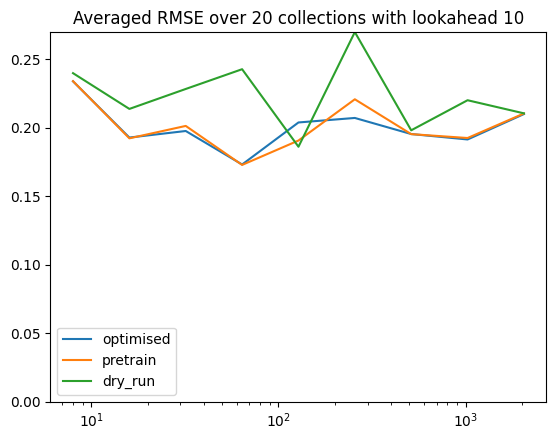

In [41]:
cumulative_data = [[], [], []]
for i in range(20):
    print('Graph', i+1)
    _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=10, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=i==19)

Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Graph 10
Graph 11
Graph 12
Graph 13
Graph 14
Graph 15
Graph 16
Graph 17
Graph 18
Graph 19
Graph 20


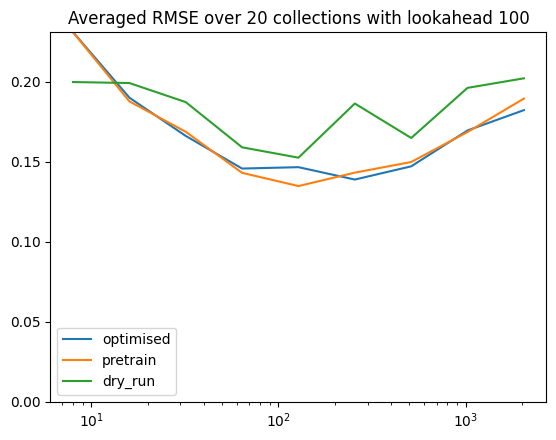

In [42]:
cumulative_data = [[], [], []]
for i in range(20):
    print('Graph', i+1)
    _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=100, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=i==19)

Graph 1
Graph 2
Graph 3
Graph 4
Graph 5
Graph 6
Graph 7
Graph 8
Graph 9
Graph 10
Graph 11
Graph 12
Graph 13
Graph 14
Graph 15
Graph 16
Graph 17
Graph 18
Graph 19
Graph 20


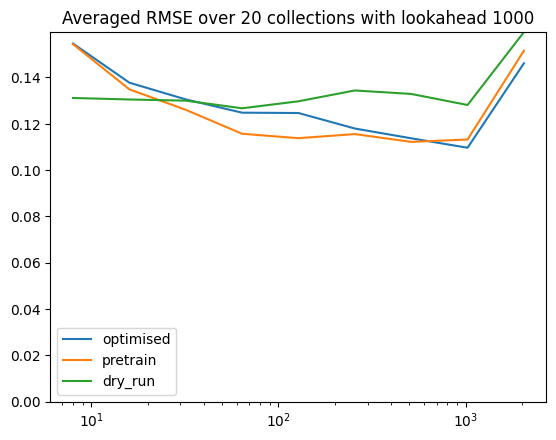

In [43]:
cumulative_data = [[], [], []]
for i in range(20):
    print('Graph', i+1)
    _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=1000, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=i==19)